In [112]:
import sys
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
from scipy import stats
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [113]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation', 'relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']
df_train = pd.read_csv('adult.data', names=cols, sep=",")
df_test = pd.read_csv('adult.test', names=cols, sep=",")

**One-hot encoding**

In [114]:
 def one_hot_encode(df):
    df.isin(['?']).sum(axis=0)

    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace('?',np.nan)
    df['workclass'] = df['workclass'].replace('?',np.nan)
    df['occupation'] = df['occupation'].replace('?',np.nan)

    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
    df = pd.concat([df, pd.get_dummies(df['gender'], prefix='gender')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['race'], prefix='race')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['marital'], prefix='marital')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['workclass'], prefix='workclass')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['relationship'], prefix='relationship')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['occupation'], prefix='occupation')],axis=1)
    
    # process age
    df.loc[(df['age'] >= 15) & (df['age'] <= 24) , 'age'] = 0
    df.loc[(df['age'] >= 25) & (df['age'] <= 34) , 'age'] = 1
    df.loc[(df['age'] >= 35) & (df['age'] <= 44) , 'age'] = 2
    df.loc[(df['age'] >= 45) & (df['age'] <= 54) , 'age'] = 3
    df.loc[(df['age'] >= 55) & (df['age'] <= 64) , 'age'] = 4
    df.loc[(df['age'] >= 65) , 'age'] = 5

    # process hours
    df.loc[(df['hours'] < 40), 'hours'] = 0
    df.loc[(df['hours'] == 40), 'hours'] = 1
    df.loc[(df['hours'] > 40), 'hours'] = 2

    df = df.drop(columns=['workclass', 'gender', 'fnlwgt', 'education', 'occupation', \
                      'relationship', 'marital', 'race', 'country', 'capgain', \
                      'caploss'])
    return df

# one-hot encoding (for regression mdoels)
df_train = one_hot_encode(df_train)
df_test = one_hot_encode(df_test)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**Protected, privileged**

In [4]:
# protected: 'gender_Female'=1
# privileged: 'gender_Male'=1

**Parametric Model**

In [115]:
X_train = df_train.drop(columns='income')
y_train = df_train['income']

X_test = df_test.drop(columns='income')
y_test = df_test['income']

# size=500
# X_train = X_train[0:size]
# y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=300)

**Compute statistical parity difference**

In [6]:
def computeFairness(y_pred, X_test): 
    protected_idx = X_test[X_test['gender_Female']==1].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['gender_Male']==1].index
    numPrivileged = len(privileged_idx)
    
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    spd = p_protected - p_privileged
    return spd

**Influence of points computed using ground truth**

In [7]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig) - spd_0
        delta_spd.append(delta_spd_i)
    
    return delta_spd

**Loss function** (Log loss for logistic regression)

In [8]:
def logistic_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        if (y_pred[i][1] != 0 and y_pred[i][0] != 0):
            loss += - y_true[i] * math.log(y_pred[i][1]) - (1 - y_true[i]) * math.log(y_pred[i][0])
    loss /= len(y_true)
    return loss

**Compute Accuracy** 

In [9]:
def computeAccuracy(y_true, y_pred):
    accuracy = 0
    for i in range(len(y_true)):
        idx = y_true[i]
        accuracy += y_pred[i][idx]
    accuracy /= len(y_true)
    return accuracy

**First-order derivative of loss function at z with respect to model parameters**

In [10]:
def del_L_del_theta_i(num_params, y_true, x, y_pred):
#     del_L_del_theta = np.ones((num_params, 1)) * ((1 - y_true) * y_pred[1] - y_true * y_pred[0])
    del_L_del_theta = np.ones((num_params, 1)) * (- y_true + y_pred[1])
    for j in range(1, num_params):
            del_L_del_theta[j] *=  x[j-1]
    return del_L_del_theta

**Hessian: Second-order partial derivative of loss function with respect to model parameters**

In [11]:
def hessian_one_point(num_params, x, y_pred):
    H = np.ones((num_params, num_params)) * (y_pred[0] * y_pred[1])
    for i in range(1, num_params):
        for j in range(i + 1):
            if j == 0:
                H[i][j] *= x[i-1]
            else:
                H[i][j] *= x[i-1] * x[j-1] 
    i_lower = np.tril_indices(num_params, -1)
    H.T[i_lower] = H[i_lower]     
    return H

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [12]:
def del_f_del_theta_i(num_params, x, y_pred):
    del_f_del_theta = np.ones((num_params, 1)) * (y_pred[0] * y_pred[1])
    for j in range(1, num_params):
            del_f_del_theta[j] *=  x[j-1]
    return del_f_del_theta

**Computing $v=\nabla($Statistical parity difference$)$**

In [13]:
# Return v = del(SPD)/del(theta)
def del_spd_del_theta(num_params, X_test_orig, X_test, y_pred):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    numProtected = X_test_orig['gender_Female'].sum()
    numPrivileged = X_test_orig['gender_Male'].sum()
    for i in range(len(X_test)):
        del_f_i = del_f_del_theta_i(num_params, X_test[i], y_pred[i])
        if X_test_orig.iloc[i]['gender_Male'] == 1: #privileged
            del_f_privileged = np.add(del_f_privileged, del_f_i)
        elif X_test_orig.iloc[i]['gender_Female'] == 1:
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_privileged /= numPrivileged
    del_f_protected /= numProtected
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [14]:
# Uniformly sample t points from training data 
def hessian_vector_product(num_params, n, size, v, hessian_all_points):
    if (size > n):
        size = n
    sample = random.sample(range(n), size)
    hinv_v = copy.deepcopy(v)
    for idx in range(size):
        i = sample[idx]
        hessian_i = hessian_all_points[i]
        hinv_v = np.matmul(np.subtract(np.identity(num_params), hessian_i), hinv_v)
        hinv_v = np.add(hinv_v, v)
    return hinv_v

**First-order influence computation**

In [15]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf[0][0].tolist())
    return infs

**Second-order influence computation for a group of points in subset U**

In [16]:
def second_order_influence(X_train, U, size, del_L_del_theta, hessian_all_points):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_hinv = np.zeros((num_params, 1))
    del_L_del_theta_sum = np.zeros((num_params, 1))
    hessian_U = np.zeros((num_params, num_params))
    for i in range(u):
        idx = U[i]
        hessian_U = np.add(hessian_U, s * hessian_all_points[idx])
        del_L_del_theta_sum = np.add(del_L_del_theta_sum, del_L_del_theta[idx])
    
    hinv_del_L_del_theta= np.matmul(hinv_exact, del_L_del_theta_sum)
    hinv_hessian_U = np.matmul(hinv_exact, hessian_U)
    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * np.matmul(hinv_hessian_U, hinv_del_L_del_theta)
    sum_term = np.add(term1, term2)
    return sum_term

**Metrics: Initial state**

In [17]:
clf.fit(X_train, y_train)
num_params = len(clf.coef_.transpose()) + 1 #weights and intercept; params: clf.coef_, clf.intercept_
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)
    
spd_0 = computeFairness(y_pred_test, X_test_orig)
print("Initial fairness: ", spd_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial fairness:  -0.20044233691822827
Initial loss:  0.3597551530603338
Initial accuracy:  0.7697879897394231


**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [18]:
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.insert(i, del_L_del_theta_i(num_params, y_train[i], X_train[i], y_pred_train[i]))

hessian_all_points = []
for i in range(len(X_train)):
    hessian_all_points.insert(i, hessian_one_point(num_params, X_train[i], y_pred_train[i])
                              /len(X_train))

*H^{-1} computation*

In [19]:
hexact = 1
v1 = del_spd_del_theta(num_params, X_test_orig, X_test, y_pred_test)
if hexact == 1: 
    H_exact = np.zeros((num_params, num_params))
    for i in range(len(X_train)):
        H_exact = np.add(H_exact, hessian_all_points[i])
    hinv_exact = np.linalg.pinv(H_exact) 
    hinv_v = np.matmul(hinv_exact, v1)
else: #using Hessian vector product
    size_hvp = int(len(X_train) * .01)
    hinv_v = hessian_vector_product(num_params, len(X_train), size_hvp, v1, hessian_all_points)

**Ground truth influence of each training data point**

In [20]:
# Ground truth influence
# spdgt = ground_truth_influence(X_train, y_train, X_test, X_test_orig)
# with open('delta_spd_ground_truth_v0.txt', 'w') as filehandle:
#     for listitem in delta_spd:
#         filehandle.write('%s\n' % listitem)
gt_spd = pd.read_csv('delta_spd_ground_truth_v0.txt', names=["Values"], sep=",")
gt_spd = gt_spd.values.tolist()
spdgt=[]
for i in range(len(gt_spd)):
    spdgt.append(gt_spd[i][0])

**First-order influence of each training data point**

In [21]:
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

**Correlation between first-order and ground truth influences**

Spearman rank correlation between 1st order inf and ground truth inf:  0.9758985293908202
Pearson correlation coefficient between 1st order inf and ground truth inf:  0.9905517682165959


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


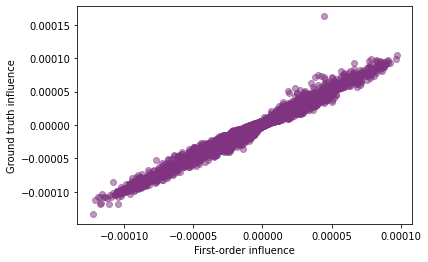

In [22]:
print("Spearman rank correlation between 1st order inf and ground truth inf: ", 
      stats.spearmanr(spdgt, infs_1)[0])
print("Pearson correlation coefficient between 1st order inf and ground truth inf: ", 
      stats.pearsonr(spdgt, infs_1)[0])

colors = (0.5,0.2,0.5)
fig = plt.figure()
plt.scatter(infs_1, spdgt, c=colors, alpha=0.5)
plt.xlabel('First-order influence')
plt.ylabel('Ground truth influence')
plt.show()

**Verification of first-order influence (implementation) on log-loss of a single point**

In [23]:
def ground_truth_influence_loss(X_train, y_train, X_test, y_test, idx):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba([X_test[idx]])[0]
    loss_0 = - y_test[idx] * math.log(y_pred[1]) - (1 - y_test[idx]) * math.log(y_pred[0])

    delta_loss = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba([X_test[idx]])[0]
        loss_i = - y_test[idx] * math.log(y_pred[1]) - (1 - y_test[idx]) * math.log(y_pred[0])
        delta_loss_i = loss_i - loss_0
        delta_loss.append(delta_loss_i)
    
    return delta_loss

verify = 0
if verify:
    # Identify data points misclassified by the model
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    for i in range(len(X_test)):
        if (y_pred[i][y_test[i]] < y_pred[i][1 - y_test[i]]):
            print(i)

    # compute loss approximated by first-order influence for a misclassified test data point
    ix = 203 
    v1 = del_L_del_theta_i(num_params, y_test[ix], X_test[ix], y_pred_test[ix])
    H_exact = np.zeros((num_params, num_params))
    for i in range(len(X_train)):
        H_exact = np.add(H_exact, hessian_all_points[i])
    hinv_exact = np.linalg.pinv(H_exact) 
    hinv_v = np.matmul(hinv_exact, v1)

    infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))
    delta_loss_gt = ground_truth_influence_loss(X_train, y_train, X_test, y_test, ix)

    colors = (0.5,0.2,0.5)
    # fig = plt.figure()
    fig, ax = plt.subplots(figsize=(4,4))
    plt.scatter(infs_1, delta_loss_gt, c=colors, alpha=0.5)
    plt.xlabel('First-order influence')
    plt.ylabel('Ground truth influence')
    ax.plot((0,1), 'r--')
    # ax.plot([0,1],[0,1], transform=ax.transAxes)
    plt.show()

**Checking ground truth, first-order and second-order influences for a set**

In [24]:
active = 0
if active:
    predicates = ['marital_Never-married', 'gender_Female']
    idx = X_train_orig[(X_train_orig[predicates[0]] == 1)
                       & (X_train_orig[predicates[1]] == 1) 
                      ].index 
    print("#Rows removed: ", len(idx))
    print("#Rows left: ", len(X_train) - len(idx))
    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    clf.fit(X, y)
    y_pred_test = clf.predict_proba(X_test)
    print("Ground truth fairness of subset: ", computeFairness(y_pred_test, X_test_orig))
    print("Ground truth influence of subset: ", computeFairness(y_pred_test, X_test_orig) - spd_0)

    del_f_1 = 0
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]
    print("First-order influence: ", del_f_1)

    size_hvp = 1
    params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
    del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
    print("Second-order influence: ", del_f_2)

**Fairness: Ground-truth subset influence vs. computed subset influences: Random subset**

In [33]:
print("Ground-truth subset, Add 1st-order inf individual, Add ground-truth inf individual, Second-order subset influence")
sampleSize = int(.2 * len(X_train))
for i in range(100):
    idx = random.sample(range(1, len(X_train)), sampleSize) 
    
    # Ground truth subset influence
    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    clf.fit(X, y)
    y_pred_test = clf.predict_proba(X_test)
    inf_gt = computeFairness(y_pred_test, X_test_orig) - spd_0
    
    # First-order subset influence
    del_f_1 = 0
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]
    
    # Second-order subset influence
    size_hvp = 1
    params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
    del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
    
#     print(inf_gt, del_f_1, del_f_2, sep=", ")

Ground-truth subset, Add 1st-order inf individual, Add ground-truth inf individual, Second-order subset influence


**Fairness: Ground-truth subset influence vs. computed subset influences: Coherent subset** 

(by coherent, we mean group of data points that share some properties)

In [26]:
print("Attribute, Value, Ground-truth subset, Add 1st-order inf individual, \
Second-order subset influence, #rowsRemoved, Accuracy")
clf.fit(X_train, y_train)
continuous_cols = ['age', 'education.num', 'hours',]
for col in X_train_orig.columns:
    if col in continuous_cols:
        vals = X_train_orig[col].unique()
    else:
        vals = [1]
    for val in vals:
#         print(col, val, sep=": ")
        idx = X_train_orig[X_train_orig[col] == val].index 
    
        X = np.delete(X_train, idx, 0)
        y = y_train.drop(index=idx, inplace=False)
        inf_gt = 0
        if len(y.unique()) > 1:
            # Ground truth subset influence
            clf.fit(X, y)
            y_pred = clf.predict_proba(X_test)
            inf_gt = computeFairness(y_pred, X_test_orig) - spd_0
            accuracy = computeAccuracy(y_test, y_pred)

        # First-order subset influence
        del_f_1 = 0            
        for i in range(len(idx)):
            del_f_1 += infs_1[idx[i]]

        # Second-order subset influence
        size_hvp = 1
        params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
        del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]

        print(col, val, inf_gt, del_f_1, del_f_2, len(idx), accuracy, sep=", ")

Attribute, Value, Ground-truth subset, Add 1st-order inf individual, Second-order subset influence, #rowsRemoved, Accuracy
age, 2, 0.001738985483057287, 0.0010442475473438184, 0.0015884611667642003, 7807, 0.7713831930870712
age, 3, 0.01186742386215106, 0.008092110416821558, 0.011438620031781773, 5621, 0.7710644297644512
age, 1, -0.008576235854335423, -0.004684600707812446, -0.0077114763640210885, 8041, 0.7670985322140986
age, 0, -0.0004915442516325585, -0.00037015894215078473, -0.0004909708024371194, 4869, 0.7674116251466035
age, 4, -0.0030169922030444107, -0.0014460030664138926, -0.002560053319390826, 2849, 0.7700913419582628
age, 5, -0.003515454473200952, -0.002627454573157027, -0.0034070006304255615, 975, 0.7691750256673835
education.num, 13, -0.0016957302517503492, -0.0014506750358219426, -0.001713755370338796, 5044, 0.7696689677640415
education.num, 9, 0.0028731538912217247, 0.0018398584816321666, 0.002659171609421306, 9840, 0.7693027595125387
education.num, 7, -0.0004669722681995

In [116]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation', 'relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']
df_train = pd.read_csv('adult.data', names=cols, sep=",")
df_test = pd.read_csv('adult.test', names=cols, sep=",")

**Space Partitioner for reducing bias**

In [117]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation', 'relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']
df_train = pd.read_csv('adult.data', names=cols, sep=",")
df_test = pd.read_csv('adult.test', names=cols, sep=",")

def preprocess(df):
    df.isin(['?']).sum(axis=0)

    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace('?',np.nan)
    df['workclass'] = df['workclass'].replace('?',np.nan)
    df['occupation'] = df['occupation'].replace('?',np.nan)

    df.loc[(df['age'] >= 15) & (df['age'] <= 24) , 'age'] = 0
    df.loc[(df['age'] >= 25) & (df['age'] <= 34) , 'age'] = 1
    df.loc[(df['age'] >= 35) & (df['age'] <= 44) , 'age'] = 2
    df.loc[(df['age'] >= 45) & (df['age'] <= 54) , 'age'] = 3
    df.loc[(df['age'] >= 55) & (df['age'] <= 64) , 'age'] = 4
    df.loc[(df['age'] >= 65) , 'age'] = 5

    df.loc[(df['hours'] < 40), 'hours'] = 0
    df.loc[(df['hours'] == 40), 'hours'] = 1
    df.loc[(df['hours'] > 40), 'hours'] = 2
    
    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
    df = df.drop(columns=['fnlwgt', 'education.num', 'country', 'capgain', 'caploss'])
    return df

df_train = preprocess(df_train)
df_test = preprocess(df_test)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train_ = df_train.drop(columns='income')
y_train_ = df_train['income']

X_test_ = df_test.drop(columns='income')
y_test_ = df_test['income']

# size=2000
# X_train = X_train[0:size]
# y_train = y_train[0:size]

# X_train_ = X_train_[0:size]
# y_train_ = y_train_[0:size]

In [122]:
def computeFairness(y_pred, X_test): 
    protected_idx = X_test[X_test['gender']=='Female'].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['gender']=='Male'].index
    numPrivileged = len(privileged_idx)
    
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    spd = p_protected - p_privileged
    return spd

def getInfluenceOfSet(indices, f, X_train, y_train, X_test, X_test_, method): 
    del_f = 0
    if (method == 1):
        X = X_train.drop(index=indices, inplace=False)
        y = y_train.drop(index=indices, inplace=False)
        if len(y.unique()) < 2:
            return 0
        clf.fit(X, y)
        y_pred = clf.predict_proba(X_test)
        del_f = computeFairness(y_pred, X_test_)
    elif (method == 2):
        for i in range(len(indices)):
            del_f += infs_1[indices[i]]
    elif (method == 3):
        size_hvp = 1
        params_f_2 = second_order_influence(X_train, indices, size_hvp, del_L_del_theta, hessian_all_points)
        del_f = np.dot(v1.transpose(), params_f_2)[0][0]
    return  del_f

def getSplitVal(infs):
    score = np.Inf
    splitColIdx = -1
    for i in range(len(infs)):
        for j in range(len(infs[i])):
            if (abs(infs[i][j]) < score):
                splitColIdx = i
                score = abs(infs[i][j])
    return splitColIdx

def getSplitAttribute(cols, predCols, predVals, 
                      X_train, y_train, X_test, X_train_, X_test_, method):
    splitCol, numRows, score, idx = None, len(X_train_), abs(spd_0), []
    X_ = copy.deepcopy(X_train_)
    
    if len(predCols) > 0:
        for i in range(len(predCols)):
            pred = predCols[i]
            val = predVals[i]
            idx = X_[X_[pred] == val].index 
            X_ = X_[X_[pred] == val]
    
    numRows = len(X_train_) - len(idx)
    infs = []
    for i in range(len(cols)):
        col = cols[i]
        infs_i = []
        vals_i = []
        colVals = X_train_[col].unique()
        for val in colVals:
            idx_i = X_[X_[col] == val].index
            infs_i.append(getInfluenceOfSet(idx_i, spd_0, X_train, y_train, X_test, X_test_, method))
        infs.append(infs_i)
           
    colIdx = getSplitVal(infs)
    splitCol = cols[colIdx]
    return {'splitCol': splitCol, 'predCols': predCols, 'predVals': predVals, 'numRows': numRows}

def partition(node, maxDepth, minSize, depth, cols, 
              X_train_, y_train_, X_train, X_test_, X_test, method):
    print("Depth: ", depth)
    if depth >= maxDepth or node['numRows'] < minSize:
        node['children'] = None
        return
    
    X_ = copy.deepcopy(X_train_)
    if len(node['predCols']) > 0:
        for i in range(len(node['predCols'])):
            pred = node['predCols'][i]
            val = node['predVals'][i]
            idx = X_[X_[pred] == val].index 
            X_ = X_[X_[pred] == val]
    
    col = node['splitCol']
    vals = X_train_[col].unique()
    child = [None] * len(vals)
    for i in range(len(vals)):
        idx = X_[X_[col] == vals[i]].index 
        X = X_train.drop(index=idx, inplace=False)
        y = y_train.drop(index=idx, inplace=False)
        X_ = X_train_.drop(index=idx, inplace=False)
        if len(X) < minSize:
            node['children'] = None
        else:
            cols_ = copy.deepcopy(cols)
            cols_.remove(col)
            predCols_temp = copy.deepcopy(node['predCols'])
            predCols_temp.append(col)
            predVals_temp = copy.deepcopy(node['predVals'])
            predVals_temp.append(vals[i])
            child[i] = getSplitAttribute(cols_, predCols_temp, predVals_temp, 
                                         X_train, y_train, X_test,  X_train_, X_test_, method)
            child[i]['predCols'] = predCols_temp
            child[i]['predVals'] = predVals_temp
            partition(child[i], maxDepth, minSize, depth + 1, cols_,  
                      X_train_, y_train_, X_train, X_test_, X_test, method)
    node['children'] = child

def buildTree(X_train_, X_train, maxDepth, minSize, method):
    cols = copy.deepcopy(X_train_.columns).tolist()
    X_train = pd.DataFrame(data=X_train, columns=X_train_orig.columns)
    root = getSplitAttribute(cols, [], [], X_train, y_train, X_test, X_train_, X_test_, method)
    print("Root: ", root)
    partition(root, maxDepth, minSize, 1, cols,
              X_train_, y_train_, X_train, X_test_, X_test, method)
    return root

method = 3
dtree = buildTree(X_train_, X_train, 2, 100, method)


Root:  {'splitCol': 'workclass', 'predCols': [], 'predVals': [], 'numRows': 30162}
Depth:  1
Depth:  2
Depth:  2
Depth:  2
Depth:  2
Depth:  2
Depth:  2
Depth:  2


In [123]:
dtree

{'splitCol': 'workclass',
 'predCols': [],
 'predVals': [],
 'numRows': 30162,
 'children': [{'splitCol': 'occupation',
   'predCols': ['workclass'],
   'predVals': ['State-gov'],
   'numRows': 28883,
   'children': None},
  {'splitCol': 'education',
   'predCols': ['workclass'],
   'predVals': ['Self-emp-not-inc'],
   'numRows': 27663,
   'children': None},
  {'splitCol': 'occupation',
   'predCols': ['workclass'],
   'predVals': ['Private'],
   'numRows': 7876,
   'children': None},
  {'splitCol': 'education',
   'predCols': ['workclass'],
   'predVals': ['Federal-gov'],
   'numRows': 29219,
   'children': None},
  {'splitCol': 'marital',
   'predCols': ['workclass'],
   'predVals': ['Local-gov'],
   'numRows': 28095,
   'children': None},
  {'splitCol': 'education',
   'predCols': ['workclass'],
   'predVals': ['Self-emp-inc'],
   'numRows': 29088,
   'children': None},
  {'splitCol': 'age',
   'predCols': ['workclass'],
   'predVals': ['Without-pay'],
   'numRows': 30148,
   'child